
# About
Coming from a SQL background and entering the world of machine learning I soon stumbled upon Pandas. It is considered a basic skill for data arranging and preprocessing when programming in python. When you are learning python from skretch it is probabily pretty obvious how to use the library. But with an SQL biased mind as mine it might be quite a bit confusing in some places. 

By now I'm using the library for about two years as part of my ML hobby in my spare time, but I'm still spending a lot of time on stackoverflow to get things done. It's time to digg into Pandas, and recalibrate my awareness how to deal with data. 

This notebook I translate some common and some advanced techniques from SQL to pandas step-by-step. I didn't just want to write a plain cheat sheet (actually Pandas has a good one to get started: [Comparison SQL](https://pandas.pydata.org/docs/getting_started/comparison/comparison_with_sql.html)). I also wanted to unwind some concepts that might be helpful for a SQL developer who now and then deals deals with pandas.

# Technical setup

The scripts will load the data into Pandas DataFrames (e.g. `df_colors`) and also into SQL tables (e.g. `colors`). You can choos between **SQLite** (because it's part of the basic python setup) or **BigQuery** (because it's fun to learn something new).
The code below is written so you can use either SQL database.  Though you need to make very few changes to the code if you use BigQuery. I marked the code with a `#BQ` or `--BQ` where you have to adjust. 

These are changes you have to make when using BigQuery:
- set the `USE_BIGQUERY` flag to `True`,
- uncomment the `<<` in the `%%sql` magic line where SQL output is written to a DataFrame (The notebook overrides the `%%bigquery` magic as `%%sql` so the code doesn't need to be changed any further.).
- Connect your google account to the notebook session.


> **Warning !**
> 
> If you use **BigQuery** keep in mind that the scripts might generate costs and you get charged! Don't use it in Production environment or with an account pointing to a Production environment!

In [1]:
# BQ:

# Either use BigQuery (True) or SQLite (False)
USE_BIGQUERY = False

## BigQuery related settings
# if using BigQuery, drop and recreate tables (True)
RECREATE_BQ_TABLES = False
DATASET_ID = 'lego'

In [2]:
!apt -y install p7zip-full p7zip-rar
#https://towardsdatascience.com/how-to-use-kaggle-datasets-in-google-colab-bca5e452a676
!pip install -q kaggle
#!mkdir ~/.kaggle
#!cp /home/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  p7zip
The following NEW packages will be installed:
  p7zip p7zip-full p7zip-rar
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 1565 kB of archives.
After this operation, 5868 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip amd64 16.02+dfsg-6 [358 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip-full amd64 16.02+dfsg-6 [1164 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 p7zip-rar amd64 16.02-2 [43.1 kB]
Fetched 1565 kB in 0s (4532 kB/s)  
debconf: delaying package configuration, since apt-utils is not installed

78Selecting previously unselected package p7zip.
(Reading database ... 16949 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-6_amd64.deb ...
7Progress: [  0%] 

In [5]:
!pip install ipython-sql -q
!pip install matplotlib -q
#!pip install sqlalchemy -q

In [6]:
!kaggle datasets download -d rtatman/lego-database
!7z x lego-database.zip -olego-database

lego-database.zip: Skipping, found more recently modified local copy (use --force to force download)

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs AMD Ryzen 3 3200G with Radeon Vega Graphics     (810F81),ASM,AES-NI)

Scanning the drive for archives:
  0M Sca        1 file, 3079487 bytes (3008 KiB)

Extracting archive: lego-database.zip
--
Path = lego-database.zip
Type = zip
Physical Size = 3079487

    
Would you like to replace the existing file:
  Path:     lego-database/colors.csv
  Size:     3533 bytes (4 KiB)
  Modified: 2019-09-20 19:25:20
with the file from archive:
  Path:     colors.csv
  Size:     3533 bytes (4 KiB)
  Modified: 2019-09-20 19:25:20
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? ^C
(Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 

In [8]:
#https://cloud.google.com/bigquery/docs/pandas-gbq-migration
!pip install google-cloud-bigquery==2.0.0 -q
!pip install google-cloud-bigquery-storage==2.0.0 -q
!pip install pandas==1.1.3 -q
!pip install pandas-gbq==0.14.0 -q
!pip install pyarrow==1.0.1 -q
!pip install grpcio==1.32.0 -q

In [9]:
import sqlite3
import sqlalchemy
import os
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import pandas as pd
import numpy as np
import sql2pandas_config

#https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries
from google.cloud import bigquery
from google.cloud.bigquery import magics

# Path to Google credentials (*.json)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]=sql2pandas_config.GOOGLE_APPLICATION_CREDENTIALS
in_path = Path('./lego-database')

# Config

### Magics

In [10]:
# sql magic
if USE_BIGQUERY:

    %load_ext google.cloud.bigquery
    # define %%sql as an alias for %%bigquery
    %alias_magic sql bigquery

else:
    # load jupyter extention
    %load_ext sql
    # disable autocommit
    %config SqlMagic.autocommit=False

#%matplotlib inline
#%pylab inline

## Set up BigQuery

In [ ]:
client = bigquery.Client()
BQ_PROJECT = client.project
BQ_PROJECT

In [12]:
if USE_BIGQUERY:
    client = bigquery.Client()
    BQ_PROJECT = client.project
    
    default_config = bigquery.QueryJobConfig(
        default_dataset = f'{BQ_PROJECT}.{DATASET_ID}',
        maximum_bytes_billed = 100000000
    )
    client.default_query_job_config = default_config
    
    # setting config to the %%sql magic 
    magics.context.default_query_job_config = default_config

    
    # create data 'lego' set if not exists
    ds_exists = False

    for ds in list(client.list_datasets()):
        if ds.dataset_id == DATASET_ID:
            ds_exists = True
            print(f'Dataset {BQ_PROJECT}.{ds.dataset_id} already exists.')
            break;

    if not ds_exists:
        dataset = bigquery.Dataset(f'{BQ_PROJECT}.{DATASET_ID}')
        dataset = client.create_dataset(dataset, timeout=30)  # Make an API request.
        print(f'Created dataset {BQ_PROJECT}.{dataset.dataset_id}')  

## Set up SQLite

In [13]:
if not USE_BIGQUERY:
    %sql sqlite://

    conn = %sql -l
    conn = conn.get('sqlite://')
    
    # Test connection
    v1 = "Ready to go!"
    %sql df_test << SELECT :v1 as "Test"
    assert(df_test.DataFrame().values[0]==v1)
    

 * sqlite://
Done.
Returning data to local variable df_test


## Loading the data into DataFrames and into SQL database

#### Load dataframes

In [14]:
df_colors = pd.read_csv(in_path/'colors.csv')
df_inventories = pd.read_csv(in_path/'inventories.csv')
df_inventory_parts = pd.read_csv(in_path/'inventory_parts.csv')
df_inventory_sets = pd.read_csv(in_path/'inventory_sets.csv')
df_part_categories = pd.read_csv(in_path/'part_categories.csv')
df_parts = pd.read_csv(in_path/'parts.csv')
df_sets = pd.read_csv(in_path/'sets.csv')
df_themes = pd.read_csv(in_path/'themes.csv')

table_dict = {'colors': df_colors, 
             'inventories': df_inventories, 
             'inventory_parts': df_inventory_parts, 
             'inventory_sets': df_inventory_sets, 
             'part_categories': df_part_categories, 
             'parts': df_parts, 
             'sets': df_sets, 
             'themes': df_themes}

#### Load sql tables

In [15]:

if USE_BIGQUERY:
# https://cloud.google.com/bigquery/docs/pandas-gbq-migration#loading_a_pandas_dataframe_to_a_table
    
    if RECREATE_BQ_TABLES:
        for tbl in table_dict:
            job = client.delete_table(table= f'lego.{tbl}', not_found_ok = True)
            #wait for job to finish
            if job!=None: 
                job.result()
            job = client.load_table_from_dataframe(table_dict[tbl], f'lego.{tbl}')
            #wait for job to finish
            job.result()
    else:
        print('Skipped table init')

    display(client.query('select count(*) from `lego.colors` limit 1000', project=BQ_PROJECT).to_dataframe())

else:
    # SQLite
    for tbl in table_dict:
        table_dict[tbl].to_sql(tbl, con=conn.session, if_exists='replace', index = False)

    %sql SELECT tbl_name FROM sqlite_schema

 * sqlite://
Done.


# Table of contents

* [SQL and Pandas](#sql_and_pandas)
* [Missing bricks](#missing_bricks)
* [A simple Filter *(The behaviour of brackets.)*](#simple_filter)
* [Indexing *(What actually is an index?)*](#indexing)
* [Joins *(Why merge doesn't mean upsert.)*](#joins)
* [Conditional Joins and Aggregation (*Almost done!*)](#agg)
* [Recursion (*Lost in trees?!*)](#rec)
* [Summary *(Got it!)*](#sum)
* [References](#ref)

<a id="sql_and_pandas"></a>
# SQL ~~vs.~~ and Pandas

I love SQL. It's been around for decades to arrange and analyse data. Data is kept in tables which are stored in a relational structure. Consistancy and data integraty is kept in mind when designing a relational data model.

However, when it comes to machine learning other data structures such as matrices and tensors become important to feat the underlying algorithms and make data processing more efficient.

That's where Pandas steps in. From a SQL-developer perspective it is the library to close the gap between your data storage and the ml frameworks.

<a id="missing_bricks"></a>
# Missing bricks

First listen to this imaginary dialogue that guides us throug the coding:

<span style="color:green">*I miss all red bricks of the Lego Pizzeria. I definetly need a new one.*</span>

<span style="color:blue">*Don't worry. We can try to solve this with data. That will be fun. :-)*</span>

<span style="color:green">*!@#%&*</span>

Now that we have the database set up and a mission we are ready to figuere out how to deal with missing bricks.
First we inspect the tables. They are organized as shown in the relational diagram.

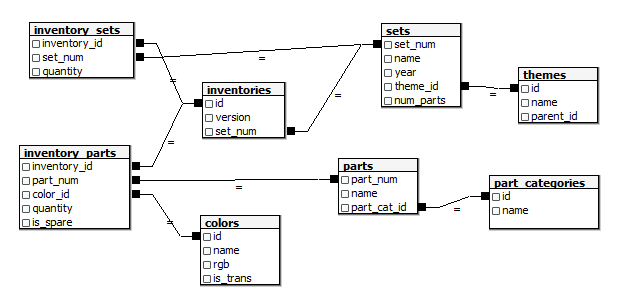

In [16]:
Image.open(in_path/'downloads_schema.png')

There are colors, parts, sets and inventories. We should start by searching for the *Pizzeria* in the `set` table using the set number (*41311*).
![Pizzeria](https://raw.githubusercontent.com/joatom/blog-resources/main/handful_bricks/img/piz.png)

<a id = "simple_filter"></a>
# A simple Filter *(The behaviour of brackets.)*

A simple `like`-filter on the `sets` table will return the set info.

```sql
SELECT *
  FROM sets s
 WHERE s.set_num like '41311%'
```


In [17]:
%%sql
    
SELECT *
  FROM sets s
 WHERE s.set_num like '41311%'

 * sqlite://
Done.


set_num,name,year,theme_id,num_parts
41311-1,Heartlake Pizzeria,2017,494,287


There are several ways to apply a filter in Pandas. The most SQL-like code utilizes the `query`-function which basicaly substitutes the `where` clause.

In [18]:
df_sets.query("set_num.str.contains('41311')", engine='python')

,set_num,name,year,theme_id,num_parts
3582,41311-1,Heartlake Pizzeria,2017,494,287


Since the `query` function expects a String as input parameter we loose syntax highlighting and syntax checking for our filter expression.

Therefore a more commonly used expression consists of the **bracket notation** (The behaviour of the bracket notation of a class in python is implementated in the class function `__getitem__`).

See how we can apply an equals filter using brackets.

In [19]:
df_sets[df_sets.set_num == '41311-1']

# or

df_sets[df_sets['set_num'] == '41311-1']

,set_num,name,year,theme_id,num_parts
3582,41311-1,Heartlake Pizzeria,2017,494,287


There is a lot going on in this expression.

Let's take it apart.

`df_sets['set_num']` returns a single column (a Pandas.Series object). A Pandas Dataframe is basically a collection of Series. Additionaly there is a row index (often just called *index*) and a column index (*columnnames*). Think of a column store database.

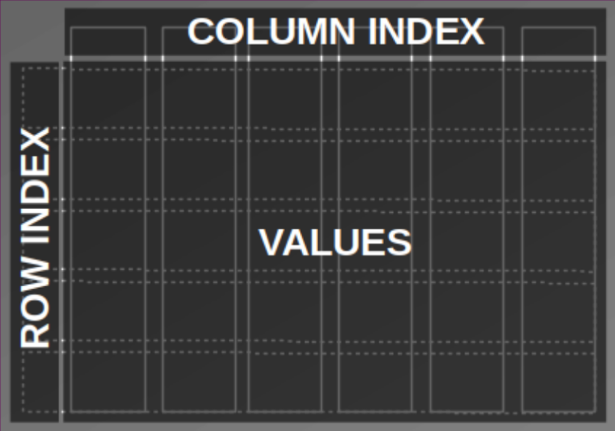

In [20]:
Image.open('./img/df.png')

Applying a boolean condition (`== '41311-1'`) to a Series of the DataFrame (`df_sets['set_num']`) will result in a boolean collection of the size of the column.

In [21]:
bool_coll = df_sets['set_num'] == '41311-1'

# only look at the position 3580 - 3590 of the collection
bool_coll[3580:3590]

3580    False
3581    False
3582     True
3583    False
3584    False
3585    False
3586    False
3587    False
3588    False
3589    False
Name: set_num, dtype: bool

The boolean collection now gets past to the DataFrame and filters the rows:
```python
df_sets[bool_coll]
# or 
df_sets[df_sets['set_num'] == '41311-1']
```
Depending on what type of object we pass to the square brackets the outcome result in very different behaviours. 

We have already seen in the example above that if we pass a **boolean collection** with the size of number of rows, the collection is been handled as a **row filter**. 

But if we pass a column name or a **list of column** names to the brackets instead, the given columns are selected like in the `SELECT` clause of an SQL statement. 
```sql
SELECT name,
       year
  FROM lego.sets;
```
=> 
```python
df_sets[['name', 'year']]
```

Row filter and column selection can be combined like this:
```sql
SELECT s.name,
       s.year
  FROM lego.sets s
 WHERE s.set_num = '41311-1';
```
=>

In [22]:
df_temp = df_sets[df_sets['set_num'] == '41311-1']
df_temp[['name','year']]

# or simply:

df_sets[df_sets['set_num'] == '41311-1'][['name','year']]

,name,year
3582,Heartlake Pizzeria,2017


<a id = "indexing"></a>
# Indexing *(What actually is an index?)*

Another way to access a row in pandas is by using the row index. With the `loc` function (and brackets) we select the *Pizzeria* and another arbitrary set. We use the row numbers to filter the rows.

In [23]:
df_sets.loc[[236, 3582]]

,set_num,name,year,theme_id,num_parts
236,10255-1,Assembly Square,2017,155,4009
3582,41311-1,Heartlake Pizzeria,2017,494,287


If we inspect the DataFrame closely we realize that it doesn't realy look like a simple table but rather like a **cross table**. 

The first column on the left is a row index and the table header is the column index. In the center the values of the columns are displayed. 

If we think of the values as a matrix the rows are dimension 0 and columns are dimension 1. The dimension is often used in DataFrame functions as `axis` parameter. E.g. dropping columns can be done using dimensional information:

```sql
-- EXCEPT in SELECT clause only works with BIGQUERY
SELECT s.* EXCEPT s.year
  FROM lego.sets s;
```

==> 

In [24]:
# %%sql SELECT s.* EXCEPT s.year FROM lego.sets s LIMIT 5;

In [25]:
df_sets.drop(['year'], axis = 1).head(5)

,set_num,name,theme_id,num_parts
0,00-1,Weetabix Castle,414,471
1,0011-2,Town Mini-Figures,84,12
2,0011-3,Castle 2 for 1 Bonus Offer,199,2
3,0012-1,Space Mini-Figures,143,12
4,0013-1,Space Mini-Figures,143,12


The indexes can be accessed with the `index` and `columns` variable. `axes` contains both.

In [26]:
df_sets.index # row index
df_sets.columns # column index

df_sets.axes # both

[RangeIndex(start=0, stop=11673, step=1),
 Index(['set_num', 'name', 'year', 'theme_id', 'num_parts'], dtype='object')]

The row index doesn't necessarely be the row number. We can also convert a column into a row index.

In [27]:
df_sets.set_index('set_num').head()

,name,year,theme_id,num_parts
set_num,,,,
00-1,Weetabix Castle,1970,414,471
0011-2,Town Mini-Figures,1978,84,12
0011-3,Castle 2 for 1 Bonus Offer,1987,199,2
0012-1,Space Mini-Figures,1979,143,12
0013-1,Space Mini-Figures,1979,143,12


It is also possible to define hierarchicle indicies for multi dimensional representation. 

In [28]:
df_sets.set_index(['year', 'set_num']).sort_index(axis=0).head() # axis = 0 => row index

name  theme_id  \
year set_num                                                                  
1950 700.1.1-1                            Individual 2 x 4 Bricks       371   
     700.1.2-1                            Individual 2 x 2 Bricks       371   
     700.A-1    Automatic Binding Bricks Small Brick Set (Lego...       366   
     700.B.1-1        Individual 1 x 4 x 2 Window (without glass)       371   
     700.B.2-1        Individual 1 x 2 x 3 Window (without glass)       371   

                num_parts  
year set_num               
1950 700.1.1-1         10  
     700.1.2-1          9  
     700.A-1           24  
     700.B.1-1          7  
     700.B.2-1          7

Sometimes it is usefull to reset the index, hence reset the row numbers.

In [29]:
df_sets.loc[[236, 3582]].reset_index(drop = True) # set drop = False to keep the old index as new column

,set_num,name,year,theme_id,num_parts
0,10255-1,Assembly Square,2017,155,4009
1,41311-1,Heartlake Pizzeria,2017,494,287


Now we get a sence what is meant by an index in pandas in contrast to SQL.

**Indices in SQL** are hidden data structures (in form of e.g. b-trees or hash-tables). They are built to **access data more quickly**, to avoiding full table scans when appropriate or to mantain consistancies when used with constraints.

An **index in Pandas** can rather be seen as a **dimensional access** to the data values. They can be distingueshed between row and column indices.

<a id = "joins"></a>
# Joins *(Why merge doesn't mean upsert.)*

<span style="color:green">*What are we gonna do now about my missing parts?*</span>

<span style="color:blue">*We don't have all the information we need, yet. We need to join the other tables.*</span>

Though there is a function called `join` to join DataFrames I always use the `merge` function. This can be a bit confusing, when you are used to Oracle where *merge* means upsert/updelete rather then combining two tables.

When combining two DataFrames with the `merge` function in Pandas we have to define the relationship more explicitly. If your used to SQL thats what you want. 

In contrast the `join` function implicitly combines the DataFrames by their index or column names. It also enables multiply DataFrame joins in one statement as long as the join columns are matchable by name.

In [30]:
%%sql
SELECT * 
  FROM sets s
 INNER JOIN
       inventories i
    ON s.set_num = i.set_num -- USING (set_num)
LIMIT 5

 * sqlite://
Done.


set_num,name,year,theme_id,num_parts,id,version,set_num_1
00-1,Weetabix Castle,1970,414,471,5574,1,00-1
0011-2,Town Mini-Figures,1978,84,12,5087,1,0011-2
0011-3,Castle 2 for 1 Bonus Offer,1987,199,2,2216,1,0011-3
0012-1,Space Mini-Figures,1979,143,12,1414,1,0012-1
0013-1,Space Mini-Figures,1979,143,12,4609,1,0013-1


Those Pandas statements all do the same:

In [31]:
df_sets.merge(df_inventories, how = 'inner', on = 'set_num').head(5)

#or if columns are matching

df_sets.merge(df_inventories, on = 'set_num').head(5)

#or explicitly defined columns

df_sets.merge(df_inventories, how = 'inner', left_on = 'set_num', right_on = 'set_num').head(5)


,set_num,name,year,theme_id,num_parts,id,version
0,00-1,Weetabix Castle,1970,414,471,5574,1
1,0011-2,Town Mini-Figures,1978,84,12,5087,1
2,0011-3,Castle 2 for 1 Bonus Offer,1987,199,2,2216,1
3,0012-1,Space Mini-Figures,1979,143,12,1414,1
4,0013-1,Space Mini-Figures,1979,143,12,4609,1


To see witch parts are needed for the *Pizzeria* we combine some tables. We look for the inventory of the set and gather all parts. Then we get color and part category information.

We end up with an inventory list:

In [32]:
%%sql
SELECT s.set_num, 
       s.name set_name, 
       p.part_num, 
       p.name part_name, 
       ip.quantity,
       c.name color,
       pc.name part_cat
  FROM sets s,
       inventories i,
       inventory_parts ip,
       parts p,
       colors c,
       part_categories pc
 WHERE s.set_num = i.set_num
   AND i.id = ip.inventory_id
   AND ip.part_num = p.part_num
   AND ip.color_id = c.id
   AND p.part_cat_id = pc.id 
   AND s.set_num in ('41311-1')
   AND i.version = 1
   AND ip.is_spare = 'f'
 ORDER BY p.name, s.set_num, c.name
LIMIT 10

 * sqlite://
Done.


set_num,set_name,part_num,part_name,quantity,color,part_cat
41311-1,Heartlake Pizzeria,25269pr03,1/4 CIRCLE TILE 1X1 with Pizza Print,4,Tan,Tiles Printed
41311-1,Heartlake Pizzeria,32807,"BRICK 1X1X1 1/3, W/ ARCH",4,Red,Other
41311-1,Heartlake Pizzeria,6190,"Bar 1 x 3 (Radio Handle, Phone Handset)",1,Red,"Bars, Ladders and Fences"
41311-1,Heartlake Pizzeria,30374,Bar 4L (Lightsaber Blade / Wand),1,Light Bluish Gray,"Bars, Ladders and Fences"
41311-1,Heartlake Pizzeria,99207,Bracket 1 x 2 - 2 x 2 Inverted,1,Black,Plates Special
41311-1,Heartlake Pizzeria,2453b,Brick 1 x 1 x 5 with Solid Stud,4,Tan,Bricks
41311-1,Heartlake Pizzeria,3004,Brick 1 x 2,4,Light Bluish Gray,Bricks
41311-1,Heartlake Pizzeria,3004,Brick 1 x 2,3,Tan,Bricks
41311-1,Heartlake Pizzeria,3004,Brick 1 x 2,1,White,Bricks
41311-1,Heartlake Pizzeria,3245b,Brick 1 x 2 x 2 with Inside Axle Holder,2,White,Bricks


Lets create a general `inventory_list` as view and make the statement more readable and comparable with ANSI-syntax (separating filters/predicates from join conditions).

In [33]:
%%sql
-- BQ: add schema infront of table, e.g. lego.colors
DROP VIEW IF EXISTS inventory_list;
CREATE VIEW inventory_list AS
SELECT s.set_num, 
       s.name set_name, 
       s.theme_id,
       s.num_parts,
       p.part_num, 
       ip.quantity,
       p.name part_name, 
       c.name color,
       pc.name part_cat
  FROM sets s
--  FROM lego.sets s
 INNER JOIN
       inventories i
--       lego.inventories i
 USING (set_num)
 INNER JOIN
       inventory_parts ip
--       lego.inventory_parts ip
    ON (i.id = ip.inventory_id)
 INNER JOIN
       parts p
--       lego.parts p
 USING (part_num)
 INNER JOIN
       colors c
--       lego.colors c
    ON (ip.color_id = c.id)
 INNER JOIN
       part_categories pc
--       lego.part_categories pc
    ON (p.part_cat_id = pc.id)
 WHERE i.version = 1
   AND ip.is_spare = 'f';


 * sqlite://
Done.
Done.


[]

Now we translate the view to pandas. We see how the structure relates to sql. The parameter `how` defines the type of join (here: `inner`), `on` represents the `USING` clause whereas `left_on` and `right_on` stand for the SQL `ON` condition.

In SQL usualy an optimizer defines based in rules or statistics the execution plan (the order in which the tables are accessed, combined and filtered). I'm not sure if pandas follows a similar approache. To be safe, I assume the order and early column dropping might matter for performance and memory management.

In [34]:
df_inventory_list = df_sets[['set_num', 'name', 'theme_id', 'num_parts']] \
                    .merge(
                    df_inventories[df_inventories['version'] == 1][['id', 'set_num']],
                        how = 'inner',
                        on = 'set_num'
                    ) \
                    .merge(
                    df_inventory_parts[df_inventory_parts['is_spare'] == 'f'][['inventory_id', 'part_num', 'color_id', 'quantity']],
                        how = 'inner',
                        left_on = 'id',
                        right_on = 'inventory_id'
                    ) \
                    .merge(
                    df_parts[['part_num', 'name', 'part_cat_id']],
                        how = 'inner',
                        on = 'part_num'
                    ) \
                    .merge(
                    df_colors[['id', 'name']],
                        how = 'inner',
                        left_on = 'color_id',
                        right_on = 'id'
                    ) \
                    .merge(
                    df_part_categories[['id', 'name']],
                        how = 'inner',
                        left_on = 'part_cat_id',
                        right_on = 'id'
                    )

# remove some columns and use index as row number (reset_index)
df_inventory_list = df_inventory_list.drop(['id_x', 'inventory_id', 'color_id', 'part_cat_id', 'id_y', 'id'], axis = 1).reset_index(drop = True)

# rename columns
df_inventory_list.columns = ['set_num', 'set_name', 'theme_id', 'num_parts', 'part_num', 'quantity', 'part_name', 'color', 'part_cat']

Lots of code here. So we better check if our pandas code matches the results of our SQL code.

Select the inventory list for our example and compare the results.

In [35]:
%%sql df_test_from_sql << 
-- BQ: remove <<
SELECT il.* 
  FROM inventory_list il
 WHERE il.set_num in ('41311-1')
 ORDER BY 
       il.part_name, 
       il.set_num, 
       il.color
LIMIT 10;

 * sqlite://
Done.
Returning data to local variable df_test_from_sql


In [36]:
# test
df_test_from_df = df_inventory_list[df_inventory_list['set_num'].isin(['41311-1'])].sort_values(by=['part_name', 'set_num', 'color']).head(10)

df_test_from_df

,set_num,set_name,theme_id,num_parts,part_num,quantity,part_name,color,part_cat
507161,41311-1,Heartlake Pizzeria,494,287,25269pr03,4,1/4 CIRCLE TILE 1X1 with Pizza Print,Tan,Tiles Printed
543292,41311-1,Heartlake Pizzeria,494,287,32807,4,"BRICK 1X1X1 1/3, W/ ARCH",Red,Other
266022,41311-1,Heartlake Pizzeria,494,287,6190,1,"Bar 1 x 3 (Radio Handle, Phone Handset)",Red,"Bars, Ladders and Fences"
273113,41311-1,Heartlake Pizzeria,494,287,30374,1,Bar 4L (Lightsaber Blade / Wand),Light Bluish Gray,"Bars, Ladders and Fences"
306863,41311-1,Heartlake Pizzeria,494,287,99207,1,Bracket 1 x 2 - 2 x 2 Inverted,Black,Plates Special
47206,41311-1,Heartlake Pizzeria,494,287,2453b,4,Brick 1 x 1 x 5 with Solid Stud,Tan,Bricks
50211,41311-1,Heartlake Pizzeria,494,287,3004,4,Brick 1 x 2,Light Bluish Gray,Bricks
45716,41311-1,Heartlake Pizzeria,494,287,3004,3,Brick 1 x 2,Tan,Bricks
16485,41311-1,Heartlake Pizzeria,494,287,3004,1,Brick 1 x 2,White,Bricks
22890,41311-1,Heartlake Pizzeria,494,287,3245b,2,Brick 1 x 2 x 2 with Inside Axle Holder,White,Bricks


In [37]:
# assert equals

if not USE_BIGQUERY:
    df_test_from_sql = df_test_from_sql.DataFrame()

pd._testing.assert_frame_equal(df_test_from_sql, df_test_from_df.reset_index(drop = True))

The results are equal as expected.

Since we are only interested in the red bricks we create a list of those missing parts.

In [38]:
%%sql
SELECT *
  FROM inventory_list il
 WHERE il.set_num = '41311-1'
   AND part_cat like '%Brick%'
   AND color = 'Red'
 ORDER BY 
       il.color, 
       il.part_name, 
       il.set_num;

 * sqlite://
Done.


set_num,set_name,theme_id,num_parts,part_num,quantity,part_name,color,part_cat
41311-1,Heartlake Pizzeria,494,287,3039,1,Slope 45° 2 x 2,Red,Bricks Sloped
41311-1,Heartlake Pizzeria,494,287,3045,2,Slope 45° 2 x 2 Double Convex,Red,Bricks Sloped


We need to watchout for the brackets when combining filters in Dataframes.

In [39]:
df_missing_parts = df_inventory_list[(df_inventory_list['set_num'] == '41311-1') & 
                                     (df_inventory_list['part_cat'].str.contains("Brick")) &
                                     (df_inventory_list['color'] == 'Red')
                                    ].sort_values(by=['color', 'part_name', 'set_num']).reset_index(drop = True)

df_missing_parts

,set_num,set_name,theme_id,num_parts,part_num,quantity,part_name,color,part_cat
0,41311-1,Heartlake Pizzeria,494,287,3039,1,Slope 45° 2 x 2,Red,Bricks Sloped
1,41311-1,Heartlake Pizzeria,494,287,3045,2,Slope 45° 2 x 2 Double Convex,Red,Bricks Sloped


<span style="color:blue">*There we go, we are missing one 2x2 brick and tw0 2x2 double convex.*</span>

<span style="color:green">*Yup, that's the roof of the fireplace. I knew that before.*</span>

<a id ="agg"></a>
# Conditional Joins and Aggregation *(Almost done!)*

Next we search for sets that contain the missing parts. The quantity of the parts in the found sets must be greater or equal the quantity of the missing parts.

In SQL it is done with an **conditional join** `il.quantity >= mp.quantity`.

In [40]:
%%sql sets_with_missing_parts << 
-- BQ: remove <<

-- A list of missing parts

WITH missing_parts AS (
  SELECT il.set_name,
         il.part_num, 
         il.part_name,
         il.color,
         il.quantity
    FROM inventory_list il
   WHERE il.set_num = '41311-1'
     AND il.part_cat like '%Brick%'
     AND il.color = 'Red'
)

-- Looking for set that contains as much of the missing parts as needed

SELECT mp.set_name as searching_for_set,
       il.set_num, 
       il.set_name, 
       il.part_name,
       -- total number of parts per set
       il.num_parts,
       -- how many of the missing parts were found in the set 
       COUNT(*) OVER (PARTITION BY il.set_num) AS matches_per_set
  FROM inventory_list il
 INNER JOIN
       missing_parts mp
    ON (il.part_num = mp.part_num
        AND il.color = mp.color
        -- searching for a set that contains at least as much parts as there are missing
        AND il.quantity >= mp.quantity
       )
 -- don't search in the Pizzeria set
 WHERE il.set_num <> '41311-1'
 -- prioritize sets with all the missing parts and as few parts as possible
 ORDER BY 
       matches_per_set DESC, 
       il.num_parts, 
       il.set_num,
       il.part_name
LIMIT 16

 * sqlite://
Done.
Returning data to local variable sets_with_missing_parts


## Conditional Join

There is no intuitive way to do a conditional join on DataFrames. The easiest I've [seen](https://stackoverflow.com/questions/23508351/how-to-do-workaround-a-conditional-join-in-python-pandas) so far is a two step solution.
As substitution for the SQL `WITH`-clause we can reuse `df_missing_parts`.

In [41]:
# 1. merge on the equal conditions
df_sets_with_missing_parts = df_inventory_list.merge(df_missing_parts, how = 'inner', on = ['part_num', 'color'], suffixes = ('_found', '_missing'))
# 2. apply filter for the qreater equals condition
df_sets_with_missing_parts = df_sets_with_missing_parts[df_sets_with_missing_parts['quantity_found'] >= df_sets_with_missing_parts['quantity_missing']]

# select columns
cols = ['set_num', 'set_name', 'part_name', 'num_parts']
df_sets_with_missing_parts = df_sets_with_missing_parts[['set_name_missing'] + [c + '_found' for c in cols]]
df_sets_with_missing_parts.columns = ['searching_for_set'] + cols

## Aggregation

In the next step the aggregation of the analytic function 
```sql
COUNT(*) OVER (PARTITION BY il.set_num) matches_per_set
```
needs to be calculated. Hence the number of not-NaN values will be counted per `SET_NUM` group and assigned to each row in a new column (`matches_per_set`).

But before translating the analytic function, let's have a look at a regular aggregation, first. Say, we simply want to count the entries per `set_num` on group level (without assigning the results back to the original group entries) and also sum up all parts of a group. Then the SQL would look something like this:
```sql
SELECT s.set_num,
       COUNT(*) AS matches_per_set
       SUM(s.num_parts) AS total_num_parts
  FROM ...
 WHERE ...
 GROUP BY 
       s.set_num;
```
All selected columns must either be aggregated by a function (`COUNT`, `SUM`) or defined as a group (`GROUP BY`).
The result is a two column list with the group `set_num` and the aggregations `matches_per_set` and `total_num_part`.

Now see how the counting is done with pandas.

In [42]:
df_sets_with_missing_parts.groupby(['set_num']).count()  .sort_values('set_num', ascending = False)

# for sum and count:
# df_sets_with_missing_parts.groupby(['set_num']).agg(['count', 'sum']) 

,searching_for_set,set_name,part_name,num_parts
set_num,,,,
llca8-1,1,1,1,1
llca21-1,1,1,1,1
fruit1-1,1,1,1,1
MMMB026-1,1,1,1,1
MMMB003-1,1,1,1,1
...,...,...,...,...
10021-1,1,1,1,1
088-1,1,1,1,1
080-1,2,2,2,2


Wow, that's different! The aggregation function is applied to every column independently and the group is set as row index. 
But it is also possible to define the aggregation function for each column explicitly like in SQL:

In [43]:
df_sets_with_missing_parts.groupby(['set_num'], as_index = False) \
    .agg(matches_per_set = pd.NamedAgg(column = "set_num", aggfunc = "count"), 
         total_num_parts = pd.NamedAgg(column = "num_parts", aggfunc = "sum"))

,set_num,matches_per_set,total_num_parts
0,00-4,1,126
1,066-1,1,407
2,080-1,2,1420
3,088-1,1,615
4,10021-1,1,974
...,...,...,...
463,MMMB003-1,1,15
464,MMMB026-1,1,43
465,fruit1-1,1,8
466,llca21-1,1,42


This looks more familiar. With the `as_index` argument the group becomes a column (rather than a row index).

So, now we return to our initial task translating the `COUNT(*) OVER(PARTITION BY)` clause. One approach could be to join the results of the above aggregated DataFrame with the origanal dataframe, like
```python
df_sets_with_missing_parts.merge(my_agg_df, on = 'set_num')
```
A more common why is to use the `transform()` function:

In [44]:
# add aggregatiom
df_sets_with_missing_parts['matches_per_set'] = df_sets_with_missing_parts.groupby(['set_num'])['part_name'].transform('count')

df_sets_with_missing_parts.head(5)

,searching_for_set,set_num,set_name,part_name,num_parts,matches_per_set
0,Heartlake Pizzeria,00-4,Weetabix Promotional Windmill,Slope 45° 2 x 2,126,1
1,Heartlake Pizzeria,066-1,Basic Building Set,Slope 45° 2 x 2,407,1
2,Heartlake Pizzeria,080-1,Basic Building Set with Train,Slope 45° 2 x 2,710,2
3,Heartlake Pizzeria,088-1,Super Set,Slope 45° 2 x 2,615,1
4,Heartlake Pizzeria,10021-1,U.S.S. Constellation,Slope 45° 2 x 2,974,1


Let's elaborate the magic that's happening.
```python
df_sets_with_missing_parts.groupby(['set_num'])['part_name']
```
returns a `GroupByDataFrame` which contains the group names (from `set_num`) and all row/column indicies and values related to the groups. Here only one column `['part_name']` is selected. In the next step [`transform` applies](https://github.com/pandas-dev/pandas/blob/v1.1.4/pandas/core/groupby/generic.py#L514) the given function (`count`) to each column individually but only with the values in the current group. Finaly the results are assigned to each row in the group.


Now that we have gathered all the data we arange the results so that they can be compared to the SQL data:

In [45]:
# sort and pick top 16
df_sets_with_missing_parts = df_sets_with_missing_parts.sort_values(['matches_per_set', 'num_parts', 'set_num', 'part_name'], ascending = [False, True, True, True]).reset_index(drop = True).head(16)

df_sets_with_missing_parts

,searching_for_set,set_num,set_name,part_name,num_parts,matches_per_set
0,Heartlake Pizzeria,199-1,Scooter,Slope 45° 2 x 2,41,2
1,Heartlake Pizzeria,199-1,Scooter,Slope 45° 2 x 2 Double Convex,41,2
2,Heartlake Pizzeria,212-2,Scooter,Slope 45° 2 x 2,41,2
3,Heartlake Pizzeria,212-2,Scooter,Slope 45° 2 x 2 Double Convex,41,2
4,Heartlake Pizzeria,838-1,"Red Roof Bricks Parts Pack, 45 Degree",Slope 45° 2 x 2,58,2
5,Heartlake Pizzeria,838-1,"Red Roof Bricks Parts Pack, 45 Degree",Slope 45° 2 x 2 Double Convex,58,2
6,Heartlake Pizzeria,5151-1,"Roof Bricks, Red, 45 Degrees",Slope 45° 2 x 2,59,2
7,Heartlake Pizzeria,5151-1,"Roof Bricks, Red, 45 Degrees",Slope 45° 2 x 2 Double Convex,59,2
8,Heartlake Pizzeria,811-1,"Red Roof Bricks, Steep Pitch",Slope 45° 2 x 2,59,2
9,Heartlake Pizzeria,811-1,"Red Roof Bricks, Steep Pitch",Slope 45° 2 x 2 Double Convex,59,2


In [46]:
# assert equals

if not USE_BIGQUERY:
    sets_with_missing_parts = sets_with_missing_parts.DataFrame()

pd._testing.assert_frame_equal(sets_with_missing_parts, df_sets_with_missing_parts)

The results are matching!

<span style="color:blue">We got it. We can buy the small Fire Engine to fix the roof of the fireplace. Now need for a new Pizzeria. :-)</span>

<span style="color:green">(#@§?$!*#) Are you sure your data is usefull for anything?</span>



<a id = "rec"></a>
# Recursion *(Lost in trees?)*

We solved the red brick problem. But since we have the data already open, let's have a closer look at the *Fire Engine*, set number *336-1*.

In [47]:
%%sql

SELECT s.name AS set_name,
       s.year,
       t.id,
       t.name AS theme_name,
       t.parent_id
  FROM sets s,
       themes t
 WHERE t.id = s.theme_id
   AND s.set_num = '336-1';
    

 * sqlite://
Done.


set_name,year,id,theme_name,parent_id
Fire Engine,1968,376,Fire,373.0


The *fire engine* is quiet old (from 1968) and it belongs to the theme *Fire*. 
The `themes` table also includes as column called `parent_id`. This suggests that `themes` is a hierarchical structure.
We can check this with an recursive `WITH`-clause in SQL. (*BQ: recursive WITH is not implemented in BIGQUERY. Instead you can try [LOOPs](https://towardsdatascience.com/advent-of-code-sql-bigquery-31e6a04964d4)*)

In [48]:
%%sql
WITH RECURSIVE hier(name, parent_id, level) AS ( 
    
    -- init recursion
    SELECT t.name, 
           t.parent_id, 
           0 AS level 
      FROM themes t 
     WHERE id = 376
    
    UNION ALL
    
    -- recursive call
    SELECT t.name, 
           t.parent_id, 
           h.level +1 
      FROM themes t, 
           hier h 
     WHERE t.id = h.parent_id
    
)
SELECT COUNT(1) OVER() - level AS level, 
       name as theme, 
       GROUP_CONCAT(name,' --> ') over(order by level desc) path
  FROM hier 
 ORDER BY level;

 * sqlite://
Done.


level,theme,path
1,Classic,Classic
2,Vehicle,Classic --> Vehicle
3,Fire,Classic --> Vehicle --> Fire


OK, that looks like a reasonable hierarchie. The `path` column includes the parents and grant parents of a theme.
What if we want to reverse the order of the path. Unfortunately `GROUP_CONCAT` in SQLite doesn't allow us to specify a sort order in the aggregation.
It's possible to add custom aggregation function in some databases. In SQLite we can compile [application defined function](https://www.sqlite.org/appfunc.html) or in Oracle we can define [customized aggregation function](https://docs.oracle.com/cd/B28359_01/appdev.111/b28425/aggr_functions.htm) even at runtime as types.

Quiet some steps need to be taken to make the database use costumized aggregation efficently, hence we can use them like regulare aggregation and windowing function. In Oracle for instance we have to define:
1. initial values: 
    ```plsql
    total := 0; 
    n := 0;
    ```
2. calculation per iteration step: 
    ```plsql
    total := total + this_step_value; 
    n := n + 1;
    ```
3. deletion per iteration for windowing: 
    ```plsql
    total := total - removed_step_value; 
    n := n - 1;
    ```
4. merging for parallel execution:
    ```
    total := total_worker1 + total_worker2; 
    n := n_worker1 + n_worker2; 
    ```
5. termination: 
    ```plsql
    my_avg := total / nullif(n-1, 0)
    ```

On the on hand this is pretty need, since we can do what ever we want in a manuely coded loop. On the other hand I doubt that it is very efficent when we have mto deal with lots of data. But to be fair, Recursive `WITH` isn't that fast either in SQL.

Finaly, how are we doing customized aggregation. We could do it in the loop above or we can rather use the libraries `transform` or `apply` functions.

We define a custom aggregation function `cat_sorted` and then use the `apply` function like this:

In [49]:
fire_engine_info = df_themes[df_themes['id'] == 376].copy()
fire_engine_info['level'] = 0

parent_id = fire_engine_info.parent_id.values[0]


lvl = 0
while not np.isnan(parent_id) and lvl < 10:
    lvl+= 1
    new_info = df_themes[df_themes['id'] == parent_id].copy()
    new_info['level'] = lvl
    parent_id = new_info.parent_id.values[0]
    fire_engine_info = fire_engine_info.append(new_info)

fire_engine_info['grp']=0
fire_engine_info    

,id,name,parent_id,level,grp
375,376,Fire,373.0,0,0
372,373,Vehicle,365.0,1,0
364,365,Classic,NaN,2,0


In [50]:
def cat_sorted(ser, df, val_col = None, sort_col = None):
    u=' --> '.join(df[df.id.isin(ser)].sort_values(sort_col)[val_col].values)
    return [u]

In [51]:
fire_engine_info.apply(lambda x: cat_sorted(x, fire_engine_info, 'name', 'level')) #  .rolling(10,min_periods=1).apply(lambda x: cat_sorted(x, fire_engine_info, 'name', 'level'), raw = False)

,id,name,parent_id,level,grp
0,Fire --> Vehicle --> Classic,,Vehicle --> Classic,,


We can also apply rolling or windowing behaviour.
> Note that a rolling representation or windowing on string values is not possible because Pandas only allows numeric values for those action.

In [52]:
fire_engine_info.rolling(10,min_periods=1)['level'].apply(lambda x: sum(10**x), raw = False)

375      1.0
372     11.0
364    111.0
Name: level, dtype: float64

Now we not only understand the numbers on the lego package but also have a better understandig of Pandas.

<a id="sum"></a>
# Summary *(Got it!)*

SQL stays my favourite language to access structured data arranged over many tables. Pandas shines when data already is gathered together and easily accessable (e.g. as csv file).
There are alternatives to Pandas to build ml pipelines, such as [Dask](https://docs.dask.org/en/latest/) or [CUDF](https://docs.rapids.ai/api/cudf/stable/). But learning Pandas is a good foundation to learn more of them.

<a id = "ref"></a>
# References
- The Lego dataset: https://www.kaggle.com/rtatman/lego-database
- Loading datasets from kaggle: https://towardsdatascience.com/how-to-use-kaggle-datasets-in-google-colab-bca5e452a676
- Jupyter sql magic: https://towardsdatascience.com/jupyter-magics-with-sql-921370099589
- Setting up bigquery: https://cloud.google.com/bigquery/docs/quickstarts/quickstart-client-libraries
- Bigquery and Pandas: https://cloud.google.com/bigquery/docs/pandas-gbq-migration